In [10]:
import torch
from torchtext import data, datasets
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
import time
import random

# Set random seed for reproducibility 

torch.backends.cudnn.deterministic = True

# Define the Fields for processing the dataset
tokenizer = get_tokenizer('basic_english')

TEXT = data.Field(tokenize=tokenizer, include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)

# Load the IMDb dataset
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, _ = train_data.split(split_ratio=0.1)


# Split the training data to create a validation set
# train_data, valid_data = train_data.split(random_state = torch.manual_seed(SEED))
train_data, valid_data = train_data.split(split_ratio=0.7)

# Build the vocabulary and load pre-trained word embeddings (GloVe)
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

# Create iterators for the data
BATCH_SIZE = 64

device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [11]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=False, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        # Pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        # Unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        # Concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        return self.fc(hidden)

In [12]:
import numpy as np

def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl)
    noul = torch.zeros_like(oul)

    for i in range(inl.data.shape[0]):

        inc = torch.sqrt(torch.sum(torch.square(inl.data[i]))).item()
        outg = torch.sqrt(torch.sum(torch.square(oul.data[:,i]))).item()

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.data[i]*opt
        noul[:, i] = oul.data[:,i]/opt

    inl.data = ninc
    oul.data = noul

In [13]:
l2Lambda=.0005

def binary_accuracy(preds, y):
    """Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8"""
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  # convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion, layih, layhh):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        l2P = 0
        for i in layih:
            torch.sum(torch.sqrt(torch.sum(torch.square(i)))).item()
            
        loss+=l2Lambda*l2P
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    # for i in range(len(layih)):
    #     if i > 0 and i <= len(layih)-1:
    #         neuronalNeuralBalance(layih[i-1], layih[i].T)
        
    # for i in range(len(layhh)):
    #     if i > 0 and i <= len(layhh)-1:
    #         neuronalNeuralBalance(layhh[i-1], layhh[i].T)



    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [14]:
import pickle
for i in range(5):
    INPUT_DIM = len(TEXT.vocab)
    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    OUTPUT_DIM = 1
    N_LAYERS = 5
    BIDIRECTIONAL = False
    DROPOUT = 0.5
    PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

    model = RNN(INPUT_DIM, 
                EMBEDDING_DIM, 
                HIDDEN_DIM, 
                OUTPUT_DIM, 
                N_LAYERS, 
                BIDIRECTIONAL, 
                DROPOUT, 
                PAD_IDX)

    # Load the pre-trained embeddings
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    
    # Zero the initial weights of the unknown and padding tokens
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

    optimizer = optim.Adam(model.parameters())
    criterion = nn.BCEWithLogitsLoss()

    model = model.to(device)
    criterion = criterion.to(device)
    N_EPOCHS = 100

    layih = [model.rnn.weight_ih_l0, model.rnn.weight_ih_l1]
    layhh = [model.rnn.weight_hh_l0, model.rnn.weight_hh_l1]

    best_valid_loss = float('inf')
    hist = {}

    hist['train_loss'] = []
    hist['valid_loss'] = []
    hist['train_acc'] = []
    hist['valid_acc'] = []
    for epoch in range(N_EPOCHS):

        

        start_time = time.time()
        
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, layih, layhh)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
        end_time = time.time()

        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'modelRNNIMDBL22L{i}.pt')

        hist['train_loss'].append(train_loss)
        hist['valid_loss'].append(valid_loss)
        hist['train_acc'].append(train_acc)
        hist['valid_acc'].append(valid_acc)
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    with open(f'histRNNIMDBL22L{i}.pkl', 'wb') as file:
        pickle.dump(hist, file)

Epoch: 01 | Epoch Time: 0.0m 2.807669162750244s
	Train Loss: 0.695 | Train Acc: 49.07%
	 Val. Loss: 0.693 |  Val. Acc: 48.83%
Epoch: 02 | Epoch Time: 0.0m 2.2266769409179688s
	Train Loss: 0.693 | Train Acc: 51.32%
	 Val. Loss: 0.692 |  Val. Acc: 55.20%
Epoch: 03 | Epoch Time: 0.0m 2.178161859512329s
	Train Loss: 0.676 | Train Acc: 57.63%
	 Val. Loss: 0.617 |  Val. Acc: 68.51%
Epoch: 04 | Epoch Time: 0.0m 2.2467455863952637s
	Train Loss: 0.635 | Train Acc: 65.33%
	 Val. Loss: 0.595 |  Val. Acc: 69.71%
Epoch: 05 | Epoch Time: 0.0m 2.247150182723999s
	Train Loss: 0.581 | Train Acc: 69.28%
	 Val. Loss: 0.576 |  Val. Acc: 71.84%
Epoch: 06 | Epoch Time: 0.0m 2.224365472793579s
	Train Loss: 0.546 | Train Acc: 74.02%
	 Val. Loss: 0.595 |  Val. Acc: 67.91%
Epoch: 07 | Epoch Time: 0.0m 2.214515447616577s
	Train Loss: 0.468 | Train Acc: 79.31%
	 Val. Loss: 0.499 |  Val. Acc: 77.72%
Epoch: 08 | Epoch Time: 0.0m 2.2213287353515625s
	Train Loss: 0.450 | Train Acc: 80.65%
	 Val. Loss: 0.638 |  Val. A

/baldig/proteomics2/ian/Neural-Balance


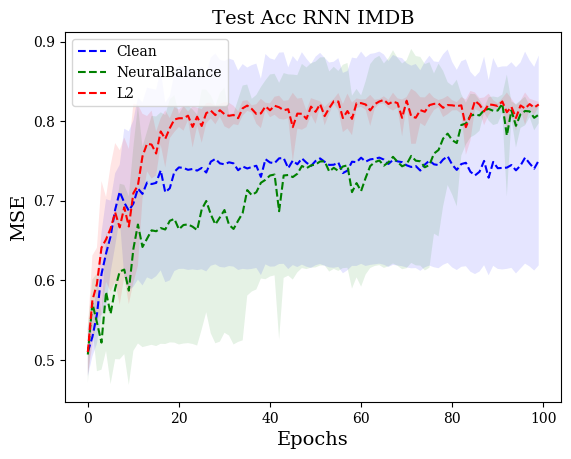

[[0.49564085 0.65506114 0.63870018 0.7376019  0.69367074 0.67827219
  0.71240942 0.76002038 0.6801404  0.64237998 0.78889267 0.77904212
  0.81935009 0.78526947 0.81493433 0.73737545 0.76052989 0.81414176
  0.78657156 0.809726   0.81884058 0.81833107 0.81493433 0.8175385
  0.81493433 0.80689538 0.79127038 0.81493433 0.82195426 0.8175385
  0.7803442  0.81283968 0.81935009 0.81623642 0.82116169 0.82195426
  0.81493433 0.79670517 0.82637002 0.81544384 0.80921648 0.82325634
  0.82976676 0.82116169 0.81363225 0.80632926 0.81595335 0.78736413
  0.81125453 0.809726   0.79019475 0.82506794 0.8157269  0.82116169
  0.82506794 0.80581975 0.80400815 0.82506794 0.81516078 0.82846468
  0.82116169 0.8276721  0.82637002 0.82846468 0.82897419 0.82376585
  0.81544384 0.83157835 0.8276721  0.76522871 0.8276721  0.82116169
  0.81725544 0.81465127 0.79619565 0.82297328 0.81776495 0.81855752
  0.81776495 0.82246377 0.8216712  0.81906703 0.82036911 0.80038496
  0.82665308 0.82897419 0.81906703 0.80531023 0.82

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import os

import pickle

matplotlib.rcParams['font.family'] = 'Serif'

print(os.getcwd())

with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDB0.pkl', 'rb') as file:
    arr1 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDB1.pkl', 'rb') as file:
    arr2 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDB2.pkl', 'rb') as file:
    arr3 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDB3.pkl', 'rb') as file:
    arr4 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDB4.pkl', 'rb') as file:
    arr5 = pickle.load(file)

# Sample data: multiple vectors
data1 = np.array([
    arr1['valid_acc'],
    arr2['valid_acc'],
    arr3['valid_acc'],
    arr4['valid_acc'],
    arr5['valid_acc']
])

with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBNB0.pkl', 'rb') as file:
    arr1 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBNB1.pkl', 'rb') as file:
    arr2 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBNB2.pkl', 'rb') as file:
    arr3 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBNB3.pkl', 'rb') as file:
    arr4 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBNB4.pkl', 'rb') as file:
    arr5 = pickle.load(file)

# Sample data: multiple vectors
data2 = np.array([
    arr1['valid_acc'],
    arr2['valid_acc'],
    arr3['valid_acc'],
    arr4['valid_acc'],
    arr5['valid_acc']
])

with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBL20.pkl', 'rb') as file:
    arr1 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBL21.pkl', 'rb') as file:
    arr2 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBL22.pkl', 'rb') as file:
    arr3 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBL23.pkl', 'rb') as file:
    arr4 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBL24.pkl', 'rb') as file:
    arr5 = pickle.load(file)

# Sample data: multiple vectors
data3 = np.array([
    arr1['valid_acc'],
    arr2['valid_acc'],
    arr3['valid_acc'],
    arr4['valid_acc'],
    arr5['valid_acc']
])

# Calculate the mean and std for each point across vectors
mean_values1 = np.mean(data1, axis=0)
min_values1 = np.min(data1, axis=0)
max_values1 = np.max(data1, axis=0)
std_values1 = np.std(data1, axis=0)

mean_values2 = np.mean(data2, axis=0)
min_values2 = np.min(data2, axis=0)
max_values2 = np.max(data2, axis=0)
std_values2 = np.std(data2, axis=0)

mean_values3 = np.mean(data3, axis=0)
min_values3 = np.min(data3, axis=0)
max_values3 = np.max(data3, axis=0)
std_values3 = np.std(data3, axis=0)

plt.figure()

# X-axis values (for example, assuming sequential integers)
x_values = np.arange(len(mean_values1))

# Plotting the mean line
plt.plot(x_values, mean_values1, 'blue', label='Clean', linestyle='--')
plt.plot(x_values, mean_values2, 'green', label='NeuralBalance', linestyle='--')
plt.plot(x_values, mean_values3, 'red', label='L2', linestyle='--')

# Adding the std deviation as a shaded area
plt.fill_between(x_values, mean_values1 - std_values1, mean_values1 + std_values1, alpha=0.1, facecolor='blue')
plt.fill_between(x_values, mean_values2 - std_values2, mean_values2 + std_values2, alpha=0.1, facecolor='green')
plt.fill_between(x_values, mean_values3 - std_values3, mean_values3 + std_values3, alpha=0.1, facecolor='red')

# Adding labels and title
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.title('Test Acc RNN IMDB', fontsize=14)
plt.legend()

plt.savefig("5LayerRNNOnIMDB.pdf", dpi=1000)

# Display the plot
plt.show()

print(data3)


In [19]:
import numpy as np
ind1 = np.argmax(mean_values1)
max1 = mean_values1[ind1]
sd1 = std_values1[ind1]
print(max1, sd1)
ind2 = np.argmax(mean_values2)
max2 = mean_values2[ind2]
sd2 = std_values2[ind2]
print(max2, sd2)
ind3 = np.argmax(mean_values3)
max3 = mean_values3[ind3]
sd3 = std_values3[ind3]
print(max3, sd3)

import pandas as pd

# Define the data
data = {
    'Model': ['Clean', 'NB', 'L2'],
    'Mean Accuracy': [max1, max2, max3],  # Mean accuracy for each model
    'Std Deviation': [sd1, sd2, sd3]   # Standard deviation for each model
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)

0.7560009077191353 0.13417969530128676
0.821942937374115 0.011585730123891356
0.8268002738555273 0.00457497683196029
   Model  Mean Accuracy  Std Deviation
0  Clean       0.756001       0.134180
1     NB       0.821943       0.011586
2     L2       0.826800       0.004575


/baldig/proteomics2/ian/Neural-Balance


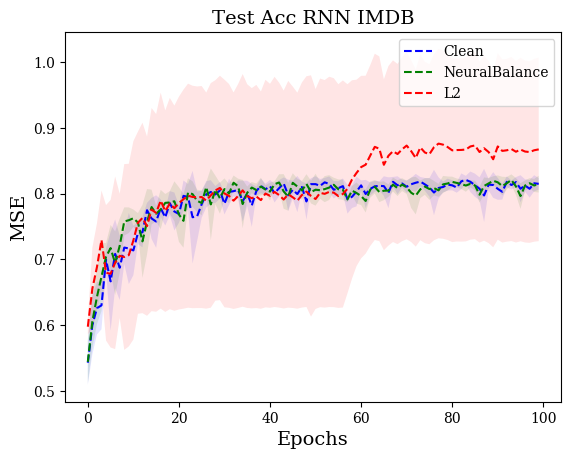

[[0.48828125 0.55202672 0.68506567 0.69706748 0.71841033 0.67906477
  0.77717392 0.68766984 0.77824955 0.77745697 0.82274683 0.79025136
  0.82484148 0.78945879 0.83163496 0.82874773 0.8235394  0.8115942
  0.82744565 0.80768795 0.82433197 0.81629303 0.83055933 0.840976
  0.83344656 0.83995697 0.82302989 0.83995697 0.83474864 0.83995697
  0.83656023 0.82693614 0.80638587 0.82302989 0.84776947 0.83786232
  0.84776947 0.85167572 0.84567482 0.84046648 0.83525815 0.84618433
  0.84176857 0.81550045 0.85609148 0.82744565 0.82382246 0.83293705
  0.84516531 0.84646739 0.79545969 0.84046648 0.85297781 0.85218523
  0.84958107 0.84907156 0.85088315 0.86180933 0.84725996 0.84024004
  0.8469769  0.82772871 0.84646739 0.85088315 0.85037364 0.8115942
  0.84307065 0.83554121 0.84256114 0.84256114 0.84776947 0.83944746
  0.83814538 0.84256114 0.82223732 0.79438406 0.82772871 0.84278759
  0.84437273 0.84176857 0.84046648 0.83423913 0.8487885  0.84046648
  0.84618433 0.85088315 0.84437273 0.83214447 0.8021

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import os

import pickle

matplotlib.rcParams['font.family'] = 'Serif'

print(os.getcwd())

with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDB2L0.pkl', 'rb') as file:
    arr1 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDB2L1.pkl', 'rb') as file:
    arr2 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDB2L2.pkl', 'rb') as file:
    arr3 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDB2L3.pkl', 'rb') as file:
    arr4 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDB2L4.pkl', 'rb') as file:
    arr5 = pickle.load(file)

# Sample data: multiple vectors
data1 = np.array([
    arr1['valid_acc'],
    arr2['valid_acc'],
    arr3['valid_acc'],
    arr4['valid_acc'],
    arr5['valid_acc']
])

with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBNB2L0.pkl', 'rb') as file:
    arr1 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBNB2L1.pkl', 'rb') as file:
    arr2 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBNB2L2.pkl', 'rb') as file:
    arr3 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBNB2L3.pkl', 'rb') as file:
    arr4 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBNB2L4.pkl', 'rb') as file:
    arr5 = pickle.load(file)

# Sample data: multiple vectors
data2 = np.array([
    arr1['valid_acc'],
    arr2['valid_acc'],
    arr3['valid_acc'],
    arr4['valid_acc'],
    arr5['valid_acc']
])

with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBL22L0.pkl', 'rb') as file:
    arr1 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBL22L1.pkl', 'rb') as file:
    arr2 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBL22L2.pkl', 'rb') as file:
    arr3 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBL22L3.pkl', 'rb') as file:
    arr4 = pickle.load(file)
with open('/baldig/proteomics2/ian/Neural-Balance/neuralBalanceIMDBRuns/hist/histRNNIMDBL22L4.pkl', 'rb') as file:
    arr5 = pickle.load(file)

# Sample data: multiple vectors
data3 = np.array([
    arr1['valid_acc'],
    arr2['valid_acc'],
    arr3['valid_acc'],
    arr4['valid_acc'],
    arr5['valid_acc']
])

# Calculate the mean and std for each point across vectors
mean_values1 = np.mean(data1, axis=0)
min_values1 = np.min(data1, axis=0)
max_values1 = np.max(data1, axis=0)
std_values1 = np.std(data1, axis=0)

mean_values2 = np.mean(data2, axis=0)
min_values2 = np.min(data2, axis=0)
max_values2 = np.max(data2, axis=0)
std_values2 = np.std(data2, axis=0)

mean_values3 = np.mean(data3, axis=0)
min_values3 = np.min(data3, axis=0)
max_values3 = np.max(data3, axis=0)
std_values3 = np.std(data3, axis=0)

plt.figure()

# X-axis values (for example, assuming sequential integers)
x_values = np.arange(len(mean_values1))

# Plotting the mean line
plt.plot(x_values, mean_values1, 'blue', label='Clean', linestyle='--')
plt.plot(x_values, mean_values2, 'green', label='NeuralBalance', linestyle='--')
plt.plot(x_values, mean_values3, 'red', label='L2', linestyle='--')

# Adding the std deviation as a shaded area
plt.fill_between(x_values, mean_values1 - std_values1, mean_values1 + std_values1, alpha=0.1, facecolor='blue')
plt.fill_between(x_values, mean_values2 - std_values2, mean_values2 + std_values2, alpha=0.1, facecolor='green')
plt.fill_between(x_values, mean_values3 - std_values3, mean_values3 + std_values3, alpha=0.1, facecolor='red')

# Adding labels and title
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.title('Test Acc RNN IMDB', fontsize=14)
plt.legend()

plt.savefig("5LayerRNNOnIMDB2L.pdf", dpi=1000)

# Display the plot
plt.show()

print(data3)


In [24]:
import numpy as np
ind1 = np.argmax(mean_values1)
max1 = mean_values1[ind1]
sd1 = std_values1[ind1]
print(max1, sd1)
ind2 = np.argmax(mean_values2)
max2 = mean_values2[ind2]
sd2 = std_values2[ind2]
print(max2, sd2)
ind3 = np.argmax(mean_values3)
max3 = mean_values3[ind3]
sd3 = std_values3[ind3]
print(max3, sd3)

import pandas as pd

# Define the data
data = {
    'Model': ['Clean', 'NB', 'L2'],
    'Mean Accuracy': [max1, max2, max3],  # Mean accuracy for each model
    'Std Deviation': [sd1, sd2, sd3]   # Standard deviation for each model
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)

0.820957883199056 0.006297834590050917
0.8209578822056454 0.008497175523586904
0.8762228270371756 0.1440385549776992
   Model  Mean Accuracy  Std Deviation
0  Clean       0.820958       0.006298
1     NB       0.820958       0.008497
2     L2       0.876223       0.144039
